Источники вдохновения:

https://arxiv.org/abs/2109.08203 - Torch.manual_seed(3407) is all you need: On the influence of random seeds in deep learning architectures for computer vision

https://arxiv.org/abs/2107.07002 - The benchmark lottery

### CIFAR10 + минимодель

In [ ]:
import torch
import torchvision 
import torchvision.transforms as transforms

import torch.optim as optim

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 32

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=False, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [28]:
import random
import numpy as np
from tqdm.notebook import tqdm
best_tests = []
for seed in tqdm(range(30)):
    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)
    net = Net()
    net.to('cuda')
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(net.parameters(), lr=0.0004)
    best_test = 0
    for epoch in range(30):  # loop over the dataset multiple times
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs = inputs.to('cuda')
            labels = labels.to('cuda')

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()

        correct = 0
        total = 0
        # since we're not training, we don't need to calculate the gradients for our outputs
        with torch.no_grad():
            for data in testloader:
                images, labels = data
                images = images.to('cuda')
                labels = labels.to('cuda')
                # calculate outputs by running images through the network
                outputs = net(images)
                # the class with the highest energy is what we choose as prediction
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        test_accuracy = correct / total
        best_test = max(test_accuracy, best_test)
    best_tests.append(best_test)
    print(best_tests)

  0%|          | 0/30 [00:00<?, ?it/s]

[0.6488]
[0.6488, 0.6581]
[0.6488, 0.6581, 0.6566]
[0.6488, 0.6581, 0.6566, 0.6479]
[0.6488, 0.6581, 0.6566, 0.6479, 0.6526]
[0.6488, 0.6581, 0.6566, 0.6479, 0.6526, 0.6284]
[0.6488, 0.6581, 0.6566, 0.6479, 0.6526, 0.6284, 0.6455]
[0.6488, 0.6581, 0.6566, 0.6479, 0.6526, 0.6284, 0.6455, 0.6651]
[0.6488, 0.6581, 0.6566, 0.6479, 0.6526, 0.6284, 0.6455, 0.6651, 0.6494]
[0.6488, 0.6581, 0.6566, 0.6479, 0.6526, 0.6284, 0.6455, 0.6651, 0.6494, 0.6556]
[0.6488, 0.6581, 0.6566, 0.6479, 0.6526, 0.6284, 0.6455, 0.6651, 0.6494, 0.6556, 0.6685]
[0.6488, 0.6581, 0.6566, 0.6479, 0.6526, 0.6284, 0.6455, 0.6651, 0.6494, 0.6556, 0.6685, 0.6485]
[0.6488, 0.6581, 0.6566, 0.6479, 0.6526, 0.6284, 0.6455, 0.6651, 0.6494, 0.6556, 0.6685, 0.6485, 0.6506]
[0.6488, 0.6581, 0.6566, 0.6479, 0.6526, 0.6284, 0.6455, 0.6651, 0.6494, 0.6556, 0.6685, 0.6485, 0.6506, 0.6461]
[0.6488, 0.6581, 0.6566, 0.6479, 0.6526, 0.6284, 0.6455, 0.6651, 0.6494, 0.6556, 0.6685, 0.6485, 0.6506, 0.6461, 0.648]
[0.6488, 0.6581, 0.6566, 0

In [29]:
best_tests = np.array(best_tests)
with open('cifar.npy', 'wb') as f:
    np.save(f, best_tests)

Text(0.5, 1.0, 'Best test accuracy with different seed')

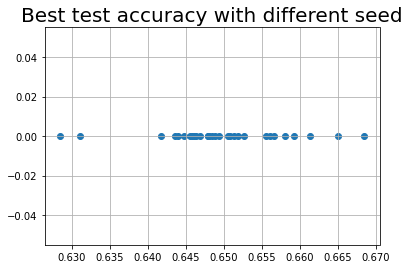

In [30]:
plt.scatter(best_tests, np.zeros(best_tests.shape))
plt.grid()
plt.title("Best test accuracy with different seed", fontsize=20)

In [31]:
best_tests.max() - best_tests.min()

0.040100000000000025

### IMDB + roberta

In [ ]:
import os
os.environ['TRANSFORMERS_OFFLINE'] = '1'
os.environ['HF_DATASETS_OFFLINE'] = '1'

In [2]:
from datasets import load_dataset

imdb = load_dataset("imdb", cache_dir='.cache')

Using the latest cached version of the module from /home/vapavlov_4/.cache/huggingface/modules/datasets_modules/datasets/imdb/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1 (last modified on Thu Mar 10 19:11:10 2022) since it couldn't be found locally at imdb.
Reusing dataset imdb (.cache/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1)


  0%|          | 0/3 [00:00<?, ?it/s]

In [3]:
from transformers import AutoTokenizer
model_name = "roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name, cache_dir='.cache')

In [4]:
def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True, max_length=30)

import numpy as np

In [5]:
tokenized_imdb = imdb.map(preprocess_function, batched=True, remove_columns=["text"]).shuffle(42)

Loading cached processed dataset at .cache/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1/cache-f90a92089c434c2c.arrow
Loading cached processed dataset at .cache/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1/cache-e5cec8ad29fe6fb0.arrow


  0%|          | 0/50 [00:00<?, ?ba/s]

Loading cached shuffled indices for dataset at .cache/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1/cache-52d17402e7f20baf.arrow
Loading cached shuffled indices for dataset at .cache/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1/cache-4b63a88884914cac.arrow


In [6]:
tokenized_imdb

DatasetDict({
    train: Dataset({
        features: ['label', 'input_ids', 'attention_mask'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['label', 'input_ids', 'attention_mask'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['label', 'input_ids', 'attention_mask'],
        num_rows: 50000
    })
})

In [7]:
val = tokenized_imdb["test"].select(range(15000))
test = tokenized_imdb["test"].select(range(15000, 25000))

In [8]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [9]:
from transformers import AutoModelForSequenceClassification

In [10]:
from datasets import load_metric
import numpy as np
import torch.nn as nn
import torch
metric = load_metric("accuracy")
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    loss_fct = nn.CrossEntropyLoss(reduction='none')
        
    loss = loss_fct(torch.tensor(logits), torch.tensor(labels))
    predictions = np.argmax(logits, axis=-1)
    acc = metric.compute(predictions=predictions, references=labels)
    return acc

Using the latest cached version of the module from /home/vapavlov_4/.cache/huggingface/modules/datasets_modules/metrics/accuracy/bbddc2dafac9b46b0aeeb39c145af710c55e03b223eae89dfe86388f40d9d157 (last modified on Tue Feb 15 18:06:21 2022) since it couldn't be found locally at accuracy, or remotely on the Hugging Face Hub.


In [ ]:
from transformers import TrainingArguments, Trainer, AutoConfig, TrainerCallback

class BestAccuracyCallback(TrainerCallback):
    "A callback that prints a message at the beginning of training"
    def __init__(self):
        self.val_accuracies = []
    def on_evaluate(self, args, state, control, metrics, **kwargs):
        self.val_accuracies.append(metrics['eval_accuracy'])

test_accuracies = []
val_accuracies = []
for seed in range(20):
    model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2, cache_dir='.cache')
    for name, param in model.named_parameters():
        if not name.startswith("classifier") and not '11' in name: # choose whatever you like here
            param.requires_grad = False
    training_args = TrainingArguments(
        output_dir="./research_imdb",
        per_device_train_batch_size=32,
        per_device_eval_batch_size=32,
        evaluation_strategy="epoch",
        logging_strategy="epoch",
        save_strategy='epoch',
        num_train_epochs=10,
        save_total_limit=1,
        load_best_model_at_end=True,
        seed=seed,
        learning_rate=2e-5,
        weight_decay=0.01,  # strength of weight decay
        max_grad_norm=1.0
    )
    callback = BestAccuracyCallback()
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_imdb["train"],
        eval_dataset=tokenized_imdb["test"],
        tokenizer=tokenizer,
        data_collator=data_collator,
        compute_metrics=compute_metrics,
        callbacks=[callback],
    )

    trainer.train()
    prediction = trainer.predict(test)
    test_accuracies.append(prediction.metrics['test_accuracy'])
    val_accuracies.extend(callback.val_accuracies)

Offline mode: forcing local_files_only=True
loading configuration file https://huggingface.co/roberta-base/resolve/main/config.json from cache at .cache/733bade19e5f0ce98e6531021dd5180994bb2f7b8bd7e80c7968805834ba351e.35205c6cfc956461d8515139f0f8dd5d207a2f336c0c3a83b4bc8dca3518e37b
Model config RobertaConfig {
  "_name_or_path": "roberta-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.16.2",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 50265
}

Offline mode: forcing local_files_only=True
l

Epoch,Training Loss,Validation Loss,Accuracy
1,0.572300,0.480487,0.755520
2,0.498400,0.466891,0.759640
3,0.482300,0.459577,0.761680
4,0.474700,0.454708,0.766640
5,0.464700,0.452247,0.769760
6,0.461700,0.460300,0.767320
7,0.457100,0.447628,0.773080
8,0.454600,0.448416,0.773760
9,0.449600,0.452319,0.770960
10,0.449500,0.450519,0.770880


***** Running Evaluation *****
  Num examples = 25000
  Batch size = 32
Saving model checkpoint to ./research_imdb/checkpoint-782
Configuration saved in ./research_imdb/checkpoint-782/config.json
Model weights saved in ./research_imdb/checkpoint-782/pytorch_model.bin
tokenizer config file saved in ./research_imdb/checkpoint-782/tokenizer_config.json
Special tokens file saved in ./research_imdb/checkpoint-782/special_tokens_map.json
Deleting older checkpoint [research_imdb/checkpoint-1564] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 25000
  Batch size = 32
Saving model checkpoint to ./research_imdb/checkpoint-1564
Configuration saved in ./research_imdb/checkpoint-1564/config.json
Model weights saved in ./research_imdb/checkpoint-1564/pytorch_model.bin
tokenizer config file saved in ./research_imdb/checkpoint-1564/tokenizer_config.json
Special tokens file saved in ./research_imdb/checkpoint-1564/special_tokens_map.json
Deleting older checkpoint [research_

Offline mode: forcing local_files_only=True
loading configuration file https://huggingface.co/roberta-base/resolve/main/config.json from cache at .cache/733bade19e5f0ce98e6531021dd5180994bb2f7b8bd7e80c7968805834ba351e.35205c6cfc956461d8515139f0f8dd5d207a2f336c0c3a83b4bc8dca3518e37b
Model config RobertaConfig {
  "_name_or_path": "roberta-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.16.2",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 50265
}

Offline mode: forcing local_files_only=True
l

Epoch,Training Loss,Validation Loss,Accuracy
1,0.570900,0.479559,0.756360
2,0.494400,0.468190,0.758320
3,0.479800,0.456039,0.766600
4,0.472100,0.462418,0.762440
5,0.466100,0.450038,0.772080
6,0.461000,0.459562,0.768560
7,0.455700,0.447391,0.772960
8,0.451900,0.452408,0.771560
9,0.451400,0.449408,0.773600
10,0.447200,0.448934,0.774120


***** Running Evaluation *****
  Num examples = 25000
  Batch size = 32
Saving model checkpoint to ./research_imdb/checkpoint-782
Configuration saved in ./research_imdb/checkpoint-782/config.json
Model weights saved in ./research_imdb/checkpoint-782/pytorch_model.bin
tokenizer config file saved in ./research_imdb/checkpoint-782/tokenizer_config.json
Special tokens file saved in ./research_imdb/checkpoint-782/special_tokens_map.json
Deleting older checkpoint [research_imdb/checkpoint-5474] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 25000
  Batch size = 32
Saving model checkpoint to ./research_imdb/checkpoint-1564
Configuration saved in ./research_imdb/checkpoint-1564/config.json
Model weights saved in ./research_imdb/checkpoint-1564/pytorch_model.bin
tokenizer config file saved in ./research_imdb/checkpoint-1564/tokenizer_config.json
Special tokens file saved in ./research_imdb/checkpoint-1564/special_tokens_map.json
Deleting older checkpoint [research_

Offline mode: forcing local_files_only=True
loading configuration file https://huggingface.co/roberta-base/resolve/main/config.json from cache at .cache/733bade19e5f0ce98e6531021dd5180994bb2f7b8bd7e80c7968805834ba351e.35205c6cfc956461d8515139f0f8dd5d207a2f336c0c3a83b4bc8dca3518e37b
Model config RobertaConfig {
  "_name_or_path": "roberta-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.16.2",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 50265
}

Offline mode: forcing local_files_only=True
l

Epoch,Training Loss,Validation Loss,Accuracy
1,0.570600,0.488288,0.748560
2,0.498100,0.469118,0.758880
3,0.481100,0.465232,0.762840
4,0.474300,0.457403,0.769760
5,0.465400,0.463516,0.763920
6,0.462100,0.451023,0.770680
7,0.458500,0.454463,0.770240
8,0.451500,0.449686,0.773280
9,0.449400,0.450436,0.774160
10,0.451500,0.449102,0.773080


***** Running Evaluation *****
  Num examples = 25000
  Batch size = 32
Saving model checkpoint to ./research_imdb/checkpoint-782
Configuration saved in ./research_imdb/checkpoint-782/config.json
Model weights saved in ./research_imdb/checkpoint-782/pytorch_model.bin
tokenizer config file saved in ./research_imdb/checkpoint-782/tokenizer_config.json
Special tokens file saved in ./research_imdb/checkpoint-782/special_tokens_map.json
Deleting older checkpoint [research_imdb/checkpoint-5474] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 25000
  Batch size = 32
Saving model checkpoint to ./research_imdb/checkpoint-1564
Configuration saved in ./research_imdb/checkpoint-1564/config.json
Model weights saved in ./research_imdb/checkpoint-1564/pytorch_model.bin
tokenizer config file saved in ./research_imdb/checkpoint-1564/tokenizer_config.json
Special tokens file saved in ./research_imdb/checkpoint-1564/special_tokens_map.json
Deleting older checkpoint [research_

Offline mode: forcing local_files_only=True
loading configuration file https://huggingface.co/roberta-base/resolve/main/config.json from cache at .cache/733bade19e5f0ce98e6531021dd5180994bb2f7b8bd7e80c7968805834ba351e.35205c6cfc956461d8515139f0f8dd5d207a2f336c0c3a83b4bc8dca3518e37b
Model config RobertaConfig {
  "_name_or_path": "roberta-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.16.2",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 50265
}

Offline mode: forcing local_files_only=True
l

Epoch,Training Loss,Validation Loss,Accuracy
1,0.564600,0.493553,0.749400
2,0.497300,0.479933,0.750600
3,0.483300,0.460891,0.766280
4,0.472600,0.456287,0.767120
5,0.466800,0.453683,0.769240
6,0.460900,0.450280,0.772720
7,0.457200,0.452798,0.772440
8,0.455100,0.449626,0.772920
9,0.449800,0.447393,0.774280
10,0.448800,0.449147,0.773440


***** Running Evaluation *****
  Num examples = 25000
  Batch size = 32
Saving model checkpoint to ./research_imdb/checkpoint-782
Configuration saved in ./research_imdb/checkpoint-782/config.json
Model weights saved in ./research_imdb/checkpoint-782/pytorch_model.bin
tokenizer config file saved in ./research_imdb/checkpoint-782/tokenizer_config.json
Special tokens file saved in ./research_imdb/checkpoint-782/special_tokens_map.json
Deleting older checkpoint [research_imdb/checkpoint-7038] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 25000
  Batch size = 32
Saving model checkpoint to ./research_imdb/checkpoint-1564
Configuration saved in ./research_imdb/checkpoint-1564/config.json
Model weights saved in ./research_imdb/checkpoint-1564/pytorch_model.bin
tokenizer config file saved in ./research_imdb/checkpoint-1564/tokenizer_config.json
Special tokens file saved in ./research_imdb/checkpoint-1564/special_tokens_map.json
Deleting older checkpoint [research_

Offline mode: forcing local_files_only=True
loading configuration file https://huggingface.co/roberta-base/resolve/main/config.json from cache at .cache/733bade19e5f0ce98e6531021dd5180994bb2f7b8bd7e80c7968805834ba351e.35205c6cfc956461d8515139f0f8dd5d207a2f336c0c3a83b4bc8dca3518e37b
Model config RobertaConfig {
  "_name_or_path": "roberta-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.16.2",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 50265
}

Offline mode: forcing local_files_only=True
l

Epoch,Training Loss,Validation Loss,Accuracy
1,0.566900,0.485702,0.754440
2,0.499200,0.472197,0.759720
3,0.483900,0.464714,0.763960
4,0.472600,0.463504,0.764440
5,0.465200,0.453527,0.768440
6,0.461700,0.453572,0.771840
7,0.457300,0.456275,0.768040
8,0.454400,0.450813,0.774560
9,0.453400,0.451335,0.773120
10,0.449700,0.450515,0.773200


***** Running Evaluation *****
  Num examples = 25000
  Batch size = 32
Saving model checkpoint to ./research_imdb/checkpoint-782
Configuration saved in ./research_imdb/checkpoint-782/config.json
Model weights saved in ./research_imdb/checkpoint-782/pytorch_model.bin
tokenizer config file saved in ./research_imdb/checkpoint-782/tokenizer_config.json
Special tokens file saved in ./research_imdb/checkpoint-782/special_tokens_map.json
Deleting older checkpoint [research_imdb/checkpoint-7038] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 25000
  Batch size = 32
Saving model checkpoint to ./research_imdb/checkpoint-1564
Configuration saved in ./research_imdb/checkpoint-1564/config.json
Model weights saved in ./research_imdb/checkpoint-1564/pytorch_model.bin
tokenizer config file saved in ./research_imdb/checkpoint-1564/tokenizer_config.json
Special tokens file saved in ./research_imdb/checkpoint-1564/special_tokens_map.json
Deleting older checkpoint [research_

Offline mode: forcing local_files_only=True
loading configuration file https://huggingface.co/roberta-base/resolve/main/config.json from cache at .cache/733bade19e5f0ce98e6531021dd5180994bb2f7b8bd7e80c7968805834ba351e.35205c6cfc956461d8515139f0f8dd5d207a2f336c0c3a83b4bc8dca3518e37b
Model config RobertaConfig {
  "_name_or_path": "roberta-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.16.2",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 50265
}

Offline mode: forcing local_files_only=True
l

Epoch,Training Loss,Validation Loss,Accuracy
1,0.570400,0.481081,0.755760
2,0.496800,0.472593,0.759960
3,0.483000,0.459189,0.766160
4,0.473200,0.462257,0.762240
5,0.464200,0.454717,0.767960
6,0.461800,0.452696,0.769040
7,0.457500,0.447643,0.774240
8,0.455300,0.448820,0.771120
9,0.452200,0.453816,0.769400
10,0.448400,0.448266,0.775560


***** Running Evaluation *****
  Num examples = 25000
  Batch size = 32
Saving model checkpoint to ./research_imdb/checkpoint-782
Configuration saved in ./research_imdb/checkpoint-782/config.json
Model weights saved in ./research_imdb/checkpoint-782/pytorch_model.bin
tokenizer config file saved in ./research_imdb/checkpoint-782/tokenizer_config.json
Special tokens file saved in ./research_imdb/checkpoint-782/special_tokens_map.json
Deleting older checkpoint [research_imdb/checkpoint-7038] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 25000
  Batch size = 32
Saving model checkpoint to ./research_imdb/checkpoint-1564
Configuration saved in ./research_imdb/checkpoint-1564/config.json
Model weights saved in ./research_imdb/checkpoint-1564/pytorch_model.bin
tokenizer config file saved in ./research_imdb/checkpoint-1564/tokenizer_config.json
Special tokens file saved in ./research_imdb/checkpoint-1564/special_tokens_map.json
Deleting older checkpoint [research_

Offline mode: forcing local_files_only=True
loading configuration file https://huggingface.co/roberta-base/resolve/main/config.json from cache at .cache/733bade19e5f0ce98e6531021dd5180994bb2f7b8bd7e80c7968805834ba351e.35205c6cfc956461d8515139f0f8dd5d207a2f336c0c3a83b4bc8dca3518e37b
Model config RobertaConfig {
  "_name_or_path": "roberta-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.16.2",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 50265
}

Offline mode: forcing local_files_only=True
l

Epoch,Training Loss,Validation Loss,Accuracy
1,0.567400,0.485038,0.751680
2,0.499000,0.473949,0.760880
3,0.482600,0.466381,0.767120
4,0.473700,0.455573,0.767000
5,0.467200,0.457030,0.769360
6,0.462200,0.450566,0.770600
7,0.457400,0.469880,0.761080
8,0.454100,0.450384,0.775480
9,0.453300,0.449986,0.774200
10,0.450000,0.450360,0.774080


***** Running Evaluation *****
  Num examples = 25000
  Batch size = 32
Saving model checkpoint to ./research_imdb/checkpoint-782
Configuration saved in ./research_imdb/checkpoint-782/config.json
Model weights saved in ./research_imdb/checkpoint-782/pytorch_model.bin
tokenizer config file saved in ./research_imdb/checkpoint-782/tokenizer_config.json
Special tokens file saved in ./research_imdb/checkpoint-782/special_tokens_map.json
Deleting older checkpoint [research_imdb/checkpoint-5474] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 25000
  Batch size = 32
Saving model checkpoint to ./research_imdb/checkpoint-1564
Configuration saved in ./research_imdb/checkpoint-1564/config.json
Model weights saved in ./research_imdb/checkpoint-1564/pytorch_model.bin
tokenizer config file saved in ./research_imdb/checkpoint-1564/tokenizer_config.json
Special tokens file saved in ./research_imdb/checkpoint-1564/special_tokens_map.json
Deleting older checkpoint [research_

Offline mode: forcing local_files_only=True
loading configuration file https://huggingface.co/roberta-base/resolve/main/config.json from cache at .cache/733bade19e5f0ce98e6531021dd5180994bb2f7b8bd7e80c7968805834ba351e.35205c6cfc956461d8515139f0f8dd5d207a2f336c0c3a83b4bc8dca3518e37b
Model config RobertaConfig {
  "_name_or_path": "roberta-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.16.2",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 50265
}

Offline mode: forcing local_files_only=True
l

Epoch,Training Loss,Validation Loss,Accuracy
1,0.566300,0.484956,0.755200
2,0.497600,0.466376,0.759880
3,0.482700,0.458964,0.765600
4,0.471700,0.452845,0.770120
5,0.466600,0.452100,0.770200
6,0.459800,0.449453,0.774160
7,0.453800,0.452401,0.772760
8,0.452800,0.448922,0.774560
9,0.449100,0.449893,0.773680
10,0.447300,0.448652,0.774320


***** Running Evaluation *****
  Num examples = 25000
  Batch size = 32
Saving model checkpoint to ./research_imdb/checkpoint-782
Configuration saved in ./research_imdb/checkpoint-782/config.json
Model weights saved in ./research_imdb/checkpoint-782/pytorch_model.bin
tokenizer config file saved in ./research_imdb/checkpoint-782/tokenizer_config.json
Special tokens file saved in ./research_imdb/checkpoint-782/special_tokens_map.json
Deleting older checkpoint [research_imdb/checkpoint-7038] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 25000
  Batch size = 32
Saving model checkpoint to ./research_imdb/checkpoint-1564
Configuration saved in ./research_imdb/checkpoint-1564/config.json
Model weights saved in ./research_imdb/checkpoint-1564/pytorch_model.bin
tokenizer config file saved in ./research_imdb/checkpoint-1564/tokenizer_config.json
Special tokens file saved in ./research_imdb/checkpoint-1564/special_tokens_map.json
Deleting older checkpoint [research_

Offline mode: forcing local_files_only=True
loading configuration file https://huggingface.co/roberta-base/resolve/main/config.json from cache at .cache/733bade19e5f0ce98e6531021dd5180994bb2f7b8bd7e80c7968805834ba351e.35205c6cfc956461d8515139f0f8dd5d207a2f336c0c3a83b4bc8dca3518e37b
Model config RobertaConfig {
  "_name_or_path": "roberta-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.16.2",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 50265
}

Offline mode: forcing local_files_only=True
l

Epoch,Training Loss,Validation Loss,Accuracy
1,0.570600,0.481046,0.756440
2,0.496600,0.469172,0.762040
3,0.482500,0.462397,0.766080
4,0.474700,0.453583,0.769760
5,0.465600,0.452998,0.771600
6,0.460500,0.448524,0.772800
7,0.458000,0.449796,0.772760
8,0.453900,0.453999,0.770080
9,0.450900,0.450606,0.771840
10,0.447500,0.451303,0.771880


***** Running Evaluation *****
  Num examples = 25000
  Batch size = 32
Saving model checkpoint to ./research_imdb/checkpoint-782
Configuration saved in ./research_imdb/checkpoint-782/config.json
Model weights saved in ./research_imdb/checkpoint-782/pytorch_model.bin
tokenizer config file saved in ./research_imdb/checkpoint-782/tokenizer_config.json
Special tokens file saved in ./research_imdb/checkpoint-782/special_tokens_map.json
Deleting older checkpoint [research_imdb/checkpoint-7038] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 25000
  Batch size = 32
Saving model checkpoint to ./research_imdb/checkpoint-1564
Configuration saved in ./research_imdb/checkpoint-1564/config.json
Model weights saved in ./research_imdb/checkpoint-1564/pytorch_model.bin
tokenizer config file saved in ./research_imdb/checkpoint-1564/tokenizer_config.json
Special tokens file saved in ./research_imdb/checkpoint-1564/special_tokens_map.json
Deleting older checkpoint [research_

Offline mode: forcing local_files_only=True
loading configuration file https://huggingface.co/roberta-base/resolve/main/config.json from cache at .cache/733bade19e5f0ce98e6531021dd5180994bb2f7b8bd7e80c7968805834ba351e.35205c6cfc956461d8515139f0f8dd5d207a2f336c0c3a83b4bc8dca3518e37b
Model config RobertaConfig {
  "_name_or_path": "roberta-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.16.2",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 50265
}

Offline mode: forcing local_files_only=True
l

Epoch,Training Loss,Validation Loss,Accuracy
1,0.572600,0.486019,0.756200
2,0.496600,0.471024,0.756760
3,0.485100,0.460217,0.762720
4,0.474500,0.458708,0.769280
5,0.465700,0.455424,0.770360
6,0.461200,0.451239,0.772120
7,0.458600,0.452119,0.770680
8,0.453100,0.453111,0.771280
9,0.451100,0.450859,0.772120
10,0.449800,0.450689,0.774080


***** Running Evaluation *****
  Num examples = 25000
  Batch size = 32
Saving model checkpoint to ./research_imdb/checkpoint-782
Configuration saved in ./research_imdb/checkpoint-782/config.json
Model weights saved in ./research_imdb/checkpoint-782/pytorch_model.bin
tokenizer config file saved in ./research_imdb/checkpoint-782/tokenizer_config.json
Special tokens file saved in ./research_imdb/checkpoint-782/special_tokens_map.json
Deleting older checkpoint [research_imdb/checkpoint-4692] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 25000
  Batch size = 32
Saving model checkpoint to ./research_imdb/checkpoint-1564
Configuration saved in ./research_imdb/checkpoint-1564/config.json
Model weights saved in ./research_imdb/checkpoint-1564/pytorch_model.bin
tokenizer config file saved in ./research_imdb/checkpoint-1564/tokenizer_config.json
Special tokens file saved in ./research_imdb/checkpoint-1564/special_tokens_map.json
Deleting older checkpoint [research_

Offline mode: forcing local_files_only=True
loading configuration file https://huggingface.co/roberta-base/resolve/main/config.json from cache at .cache/733bade19e5f0ce98e6531021dd5180994bb2f7b8bd7e80c7968805834ba351e.35205c6cfc956461d8515139f0f8dd5d207a2f336c0c3a83b4bc8dca3518e37b
Model config RobertaConfig {
  "_name_or_path": "roberta-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.16.2",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 50265
}

Offline mode: forcing local_files_only=True
l

Epoch,Training Loss,Validation Loss,Accuracy
1,0.569300,0.485724,0.754040
2,0.495400,0.477330,0.754600
3,0.482400,0.463284,0.759560
4,0.474500,0.454858,0.766280
5,0.465400,0.451272,0.770640
6,0.461800,0.459730,0.765280
7,0.457300,0.450740,0.773280
8,0.452200,0.448212,0.773920
9,0.450400,0.449192,0.774360
10,0.447100,0.449875,0.772480


***** Running Evaluation *****
  Num examples = 25000
  Batch size = 32
Saving model checkpoint to ./research_imdb/checkpoint-782
Configuration saved in ./research_imdb/checkpoint-782/config.json
Model weights saved in ./research_imdb/checkpoint-782/pytorch_model.bin
tokenizer config file saved in ./research_imdb/checkpoint-782/tokenizer_config.json
Special tokens file saved in ./research_imdb/checkpoint-782/special_tokens_map.json
Deleting older checkpoint [research_imdb/checkpoint-7038] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 25000
  Batch size = 32
Saving model checkpoint to ./research_imdb/checkpoint-1564
Configuration saved in ./research_imdb/checkpoint-1564/config.json
Model weights saved in ./research_imdb/checkpoint-1564/pytorch_model.bin
tokenizer config file saved in ./research_imdb/checkpoint-1564/tokenizer_config.json
Special tokens file saved in ./research_imdb/checkpoint-1564/special_tokens_map.json
Deleting older checkpoint [research_

Offline mode: forcing local_files_only=True
loading configuration file https://huggingface.co/roberta-base/resolve/main/config.json from cache at .cache/733bade19e5f0ce98e6531021dd5180994bb2f7b8bd7e80c7968805834ba351e.35205c6cfc956461d8515139f0f8dd5d207a2f336c0c3a83b4bc8dca3518e37b
Model config RobertaConfig {
  "_name_or_path": "roberta-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.16.2",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 50265
}

Offline mode: forcing local_files_only=True
l

Epoch,Training Loss,Validation Loss,Accuracy
1,0.567600,0.491767,0.746200
2,0.500000,0.470012,0.759800
3,0.482500,0.461239,0.764840
4,0.474600,0.458660,0.764760
5,0.468000,0.454446,0.771160
6,0.462500,0.459201,0.770680
7,0.457000,0.452340,0.771520
8,0.453800,0.454659,0.770840
9,0.449500,0.449877,0.773120
10,0.450200,0.448582,0.773800


***** Running Evaluation *****
  Num examples = 25000
  Batch size = 32
Saving model checkpoint to ./research_imdb/checkpoint-782
Configuration saved in ./research_imdb/checkpoint-782/config.json
Model weights saved in ./research_imdb/checkpoint-782/pytorch_model.bin
tokenizer config file saved in ./research_imdb/checkpoint-782/tokenizer_config.json
Special tokens file saved in ./research_imdb/checkpoint-782/special_tokens_map.json
Deleting older checkpoint [research_imdb/checkpoint-6256] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 25000
  Batch size = 32
Saving model checkpoint to ./research_imdb/checkpoint-1564
Configuration saved in ./research_imdb/checkpoint-1564/config.json
Model weights saved in ./research_imdb/checkpoint-1564/pytorch_model.bin
tokenizer config file saved in ./research_imdb/checkpoint-1564/tokenizer_config.json
Special tokens file saved in ./research_imdb/checkpoint-1564/special_tokens_map.json
Deleting older checkpoint [research_

Offline mode: forcing local_files_only=True
loading configuration file https://huggingface.co/roberta-base/resolve/main/config.json from cache at .cache/733bade19e5f0ce98e6531021dd5180994bb2f7b8bd7e80c7968805834ba351e.35205c6cfc956461d8515139f0f8dd5d207a2f336c0c3a83b4bc8dca3518e37b
Model config RobertaConfig {
  "_name_or_path": "roberta-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.16.2",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 50265
}

Offline mode: forcing local_files_only=True
l

Epoch,Training Loss,Validation Loss,Accuracy
1,0.568400,0.486188,0.754240
2,0.496500,0.465949,0.759960
3,0.480600,0.461223,0.768440
4,0.473100,0.452822,0.768480
5,0.465800,0.453175,0.771440
6,0.460600,0.447488,0.773560
7,0.457400,0.450132,0.771200
8,0.454500,0.448227,0.773760
9,0.447000,0.450197,0.773280
10,0.448300,0.448680,0.774040


***** Running Evaluation *****
  Num examples = 25000
  Batch size = 32
Saving model checkpoint to ./research_imdb/checkpoint-782
Configuration saved in ./research_imdb/checkpoint-782/config.json
Model weights saved in ./research_imdb/checkpoint-782/pytorch_model.bin
tokenizer config file saved in ./research_imdb/checkpoint-782/tokenizer_config.json
Special tokens file saved in ./research_imdb/checkpoint-782/special_tokens_map.json
Deleting older checkpoint [research_imdb/checkpoint-7038] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 25000
  Batch size = 32
Saving model checkpoint to ./research_imdb/checkpoint-1564
Configuration saved in ./research_imdb/checkpoint-1564/config.json
Model weights saved in ./research_imdb/checkpoint-1564/pytorch_model.bin
tokenizer config file saved in ./research_imdb/checkpoint-1564/tokenizer_config.json
Special tokens file saved in ./research_imdb/checkpoint-1564/special_tokens_map.json
Deleting older checkpoint [research_

Offline mode: forcing local_files_only=True
loading configuration file https://huggingface.co/roberta-base/resolve/main/config.json from cache at .cache/733bade19e5f0ce98e6531021dd5180994bb2f7b8bd7e80c7968805834ba351e.35205c6cfc956461d8515139f0f8dd5d207a2f336c0c3a83b4bc8dca3518e37b
Model config RobertaConfig {
  "_name_or_path": "roberta-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.16.2",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 50265
}

Offline mode: forcing local_files_only=True
l

Epoch,Training Loss,Validation Loss,Accuracy
1,0.571100,0.483726,0.752760
2,0.496500,0.481275,0.752640
3,0.482800,0.461709,0.763200
4,0.475300,0.460114,0.764080
5,0.467200,0.455183,0.769280
6,0.464000,0.455095,0.771360
7,0.458100,0.452408,0.772680
8,0.455100,0.451323,0.772560
9,0.450800,0.450375,0.773120
10,0.452400,0.449794,0.773040


***** Running Evaluation *****
  Num examples = 25000
  Batch size = 32
Saving model checkpoint to ./research_imdb/checkpoint-782
Configuration saved in ./research_imdb/checkpoint-782/config.json
Model weights saved in ./research_imdb/checkpoint-782/pytorch_model.bin
tokenizer config file saved in ./research_imdb/checkpoint-782/tokenizer_config.json
Special tokens file saved in ./research_imdb/checkpoint-782/special_tokens_map.json
Deleting older checkpoint [research_imdb/checkpoint-4692] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 25000
  Batch size = 32
Saving model checkpoint to ./research_imdb/checkpoint-1564
Configuration saved in ./research_imdb/checkpoint-1564/config.json
Model weights saved in ./research_imdb/checkpoint-1564/pytorch_model.bin
tokenizer config file saved in ./research_imdb/checkpoint-1564/tokenizer_config.json
Special tokens file saved in ./research_imdb/checkpoint-1564/special_tokens_map.json
Deleting older checkpoint [research_

Offline mode: forcing local_files_only=True
loading configuration file https://huggingface.co/roberta-base/resolve/main/config.json from cache at .cache/733bade19e5f0ce98e6531021dd5180994bb2f7b8bd7e80c7968805834ba351e.35205c6cfc956461d8515139f0f8dd5d207a2f336c0c3a83b4bc8dca3518e37b
Model config RobertaConfig {
  "_name_or_path": "roberta-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.16.2",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 50265
}

Offline mode: forcing local_files_only=True
l

Epoch,Training Loss,Validation Loss,Accuracy
1,0.568900,0.484351,0.753960
2,0.498700,0.470047,0.759360
3,0.483300,0.472162,0.759320
4,0.473000,0.455640,0.768600
5,0.467700,0.452779,0.770760
6,0.461200,0.452038,0.769400
7,0.455400,0.448575,0.773040
8,0.454200,0.449766,0.772920
9,0.449900,0.448500,0.773760
10,0.447600,0.449572,0.773400


***** Running Evaluation *****
  Num examples = 25000
  Batch size = 32
Saving model checkpoint to ./research_imdb/checkpoint-782
Configuration saved in ./research_imdb/checkpoint-782/config.json
Model weights saved in ./research_imdb/checkpoint-782/pytorch_model.bin
tokenizer config file saved in ./research_imdb/checkpoint-782/tokenizer_config.json
Special tokens file saved in ./research_imdb/checkpoint-782/special_tokens_map.json
Deleting older checkpoint [research_imdb/checkpoint-7038] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 25000
  Batch size = 32
Saving model checkpoint to ./research_imdb/checkpoint-1564
Configuration saved in ./research_imdb/checkpoint-1564/config.json
Model weights saved in ./research_imdb/checkpoint-1564/pytorch_model.bin
tokenizer config file saved in ./research_imdb/checkpoint-1564/tokenizer_config.json
Special tokens file saved in ./research_imdb/checkpoint-1564/special_tokens_map.json
Deleting older checkpoint [research_

Offline mode: forcing local_files_only=True
loading configuration file https://huggingface.co/roberta-base/resolve/main/config.json from cache at .cache/733bade19e5f0ce98e6531021dd5180994bb2f7b8bd7e80c7968805834ba351e.35205c6cfc956461d8515139f0f8dd5d207a2f336c0c3a83b4bc8dca3518e37b
Model config RobertaConfig {
  "_name_or_path": "roberta-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.16.2",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 50265
}

Offline mode: forcing local_files_only=True
l

Epoch,Training Loss,Validation Loss,Accuracy
1,0.568700,0.485242,0.755360
2,0.497600,0.469016,0.761520
3,0.483800,0.461036,0.763240
4,0.475100,0.453970,0.767240
5,0.467800,0.451080,0.769000
6,0.460800,0.451946,0.772080
7,0.454900,0.447575,0.772520
8,0.452400,0.449450,0.772960
9,0.449800,0.452235,0.771720
10,0.450400,0.450228,0.773640


***** Running Evaluation *****
  Num examples = 25000
  Batch size = 32
Saving model checkpoint to ./research_imdb/checkpoint-782
Configuration saved in ./research_imdb/checkpoint-782/config.json
Model weights saved in ./research_imdb/checkpoint-782/pytorch_model.bin
tokenizer config file saved in ./research_imdb/checkpoint-782/tokenizer_config.json
Special tokens file saved in ./research_imdb/checkpoint-782/special_tokens_map.json
Deleting older checkpoint [research_imdb/checkpoint-7038] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 25000
  Batch size = 32
Saving model checkpoint to ./research_imdb/checkpoint-1564
Configuration saved in ./research_imdb/checkpoint-1564/config.json
Model weights saved in ./research_imdb/checkpoint-1564/pytorch_model.bin
tokenizer config file saved in ./research_imdb/checkpoint-1564/tokenizer_config.json
Special tokens file saved in ./research_imdb/checkpoint-1564/special_tokens_map.json
Deleting older checkpoint [research_

Offline mode: forcing local_files_only=True
loading configuration file https://huggingface.co/roberta-base/resolve/main/config.json from cache at .cache/733bade19e5f0ce98e6531021dd5180994bb2f7b8bd7e80c7968805834ba351e.35205c6cfc956461d8515139f0f8dd5d207a2f336c0c3a83b4bc8dca3518e37b
Model config RobertaConfig {
  "_name_or_path": "roberta-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.16.2",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 50265
}

Offline mode: forcing local_files_only=True
l

Epoch,Training Loss,Validation Loss,Accuracy
1,0.572000,0.483534,0.754120
2,0.497400,0.466179,0.761400
3,0.482600,0.465613,0.760240
4,0.474500,0.455252,0.767600
5,0.467900,0.457889,0.765600
6,0.461300,0.452248,0.770040


***** Running Evaluation *****
  Num examples = 25000
  Batch size = 32
Saving model checkpoint to ./research_imdb/checkpoint-782
Configuration saved in ./research_imdb/checkpoint-782/config.json
Model weights saved in ./research_imdb/checkpoint-782/pytorch_model.bin
tokenizer config file saved in ./research_imdb/checkpoint-782/tokenizer_config.json
Special tokens file saved in ./research_imdb/checkpoint-782/special_tokens_map.json
Deleting older checkpoint [research_imdb/checkpoint-5474] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 25000
  Batch size = 32
Saving model checkpoint to ./research_imdb/checkpoint-1564
Configuration saved in ./research_imdb/checkpoint-1564/config.json
Model weights saved in ./research_imdb/checkpoint-1564/pytorch_model.bin
tokenizer config file saved in ./research_imdb/checkpoint-1564/tokenizer_config.json
Special tokens file saved in ./research_imdb/checkpoint-1564/special_tokens_map.json
Deleting older checkpoint [research_

In [51]:
import numpy as np
test_accuracies = np.array(test_accuracies)
val_accuracies = np.array(val_accuracies)
with open('test.npy', 'wb') as f:
    np.save(f, test_accuracies)
with open('val.npy', 'wb') as f:
    np.save(f, val_accuracies)

In [21]:
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'Test accuracy with different seed')

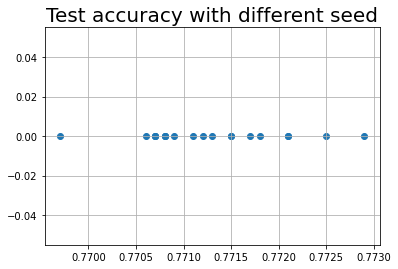

In [49]:
plt.scatter(test_accuracies, np.zeros(test_accuracies.shape))
plt.grid()
plt.title("Test accuracy with different seed", fontsize=20)

In [38]:
test_accuracies.max() - test_accuracies.min()

0.0031999999999999806

In [16]:
import numpy as np
val_accuracies = np.load('val.npy')

In [20]:
best_vals = val_accuracies.reshape((20, 10)).max(axis=1)

Text(0.5, 1.0, 'Best val accuracy with different seed')

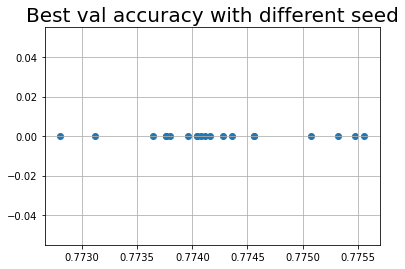

In [24]:
plt.scatter(best_vals, np.zeros(best_vals.shape))
plt.grid()
plt.title("Best val accuracy with different seed", fontsize=20)

In [25]:
best_vals.max() - best_vals.min()

0.0027599999999999847